# Naive Bayes comment classifier

In [1]:
from typing import List
import math
import pandas as pd
import numpy as np
from hazm import Normalizer, word_tokenize, Stemmer, Lemmatizer, stopwords_list
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv("comment_train.csv")
test_data = pd.read_csv("comment_test.csv")

In [3]:
train_data

,title,comment,recommend
0,زیبا اما کم دوام,با وجود سابقه خوبی که از برند ایرانی نهرین سرا...,not_recommended
1,بسیار عالی,بسیار عالی,recommended
2,سلام,من الان ۳ هفته هست استفاده میکنم\r\nبرای کسایی...,not_recommended
3,به درد نمیخورهههه,عمرش کمه تا یه هفته بیشتر نمیشه استفاده کرد یا...,not_recommended
4,کلمن آب,فکر کنین کلمن بخرین با ذوق. کلی پولشو بدین. به...,not_recommended
...,...,...,...
5995,جنسش عالیه,خیلی جنس پارچش نرم ولطیفه خیلیم جنسش خوبه اما ...,recommended
5996,خرید محصول,سلام.واقعا فکر نمی کردم به این راحتی اصلاح کنم...,recommended
5997,تعریف,من از دیجی کالا خریدم خیلی زود دستم رسید،زیبا،...,recommended
5998,اصلا چای ماچا نیسش,یا شرکت نمیدونسته چای ماچا امپریال چیه یا واقع...,not_recommended


## PreProcessing
* Title and comment: I have merged these two together but several other approaches are available such as dropping the title, giving weight to the title, etc.
* Stop words: stop words do not add any value to a sentence and we can remove them for better accuracy.
* Special characters: I have removed characters such as ., ?, ، to acheive better performance because they do not any extra value.
* Tokenizing: I have splitted the text from whitespaces to get a list of words from the text.

### Stemming and Lemmatization
Each word can be in multiple shapes for exampel رفتن برو رفت and these words present the same meaning and it's better for us to have one word for them.  
The goal of stemming and lemmatization is two reduce these different words to one single format.  

* Stemming: It usually cuts end of words in search for getting the same word format.
* Lemmatization: It is a more grammer related task and tries to convert words to their base forms. This method is more language centric.  

Examples for these methods are suggested below using hazm library

In [4]:
# Stemming
stemmer = Stemmer()
word = "روی"
stemmer.stem(word)

'رو'

In [5]:
# Lemmatization
lemmatizer = Lemmatizer()
word = "خورد"
lemmatizer.lemmatize(word).split("#")

['خورد', 'خور']

In [6]:
class PreProcessor:
    def __init__(self, df):
        self.df = df
        self.special_chars = [".", "!", "?", "؟", "،", ","]

    def merge_title_comment(self):
        self.df["title_comment"] = self.df["title"] + " " + self.df["comment"]

    def word_tokenize(self):
        self.df["tokenized"] = self.df.apply(
            lambda row: word_tokenize(row["title_comment"]), axis=1
        )

    def remove_stop_words(self):
        stop_words = stopwords_list()
        self.df["tokenized"] = self.df.apply(
            lambda row: [word for word in row["tokenized"] if word not in stop_words],
            axis=1,
        )

    def remove_special_chars(self, text: str):
        for special_char in self.special_chars:
            text = text.replace(special_char, " ")
        return text

    def remove_all_special_chars(self):
        self.df["title_comment"] = self.df.apply(
            lambda row: self.remove_special_chars(row["title_comment"]), axis=1
        )

    def normalize(self):
        normalizer = Normalizer()
        self.df["title_comment"] = self.df.apply(
            lambda row: normalizer.normalize(row["title_comment"]), axis=1
        )

    def lemmatize(self):
        lemmatizer = Lemmatizer()
        self.df["tokenized"] = self.df.apply(
            lambda row: [lemmatizer.lemmatize(word) for word in row["tokenized"]],
            axis=1,
        )

    def stem(self):
        stemmer = Stemmer()
        self.df["tokenized"] = self.df.apply(
            lambda row: [stemmer.stem(word) for word in row["tokenized"]],
            axis=1,
        )

    def simple_pre_process(self):
        self.merge_title_comment()
        self.word_tokenize()

    def pre_process(
        self,
        remove_stop_words=True,
        remove_special_chars=True,
        normalize=True,
        lemmatize=False,
        stem=False,
    ):
        self.merge_title_comment()
        if remove_special_chars:
            self.remove_all_special_chars()
        if normalize:
            self.normalize()
        self.word_tokenize()
        if remove_stop_words:
            self.remove_stop_words()
        if lemmatize:
            self.lemmatize()
        if stem:
            self.stem()

## Naive Bayes Bayes Net
<img src="Naive-Bayes-Bayesian-Network.png">

In our situation Y class is recommended/not_recommended and the features are word counts  
each feature is conditionaly independent to others. Forexample P(x1|Y) is independent to P(x2|Y)  
so we can use this formula:  
P(Y|features) has relation with P(Y) * P(f1|Y) * P(f2|Y) * ... * P(fn|Y)

* prior probabilities: P(Y) shows the prior probability and it shows our first view of the world without any further evidence. It just simply shows how many recommended or not_recommended words are in our train dataset divided by count of all rows in our data
* posterior probabilites: P(Y|features) shows the posterior probability. It means that our view has been changed by these new evidences.
* evidence: P(fi), it is the happened features, for example when we know that سلام این محصول را بخرید is recommended so this is a new raw evidence and it changes our view of the world. We do not calculate this phrase because anyway we can comare the two final values
* likelihood: P(fi|Y) is the likelihood that shows how much is the probability of seeing a word by knowing recommended/not_recommended class.

## Additive Smoothing:
There is a problem with our raw implementation of the naive bayes classifier, for example assume we did not see word اکبر in our train dataset.  
But this word is in our new data and we must assign a value for this word, using the raw implementation this probebility is 0 and it affects our final value so that it becomes zero.  
But obiously this isn't a good method and it reduces our accuracy by false labeling lots of generated zero values.  

Additive smoothing simply adds using the following formula and prevents the probabilty to become zero and affect our final value.  
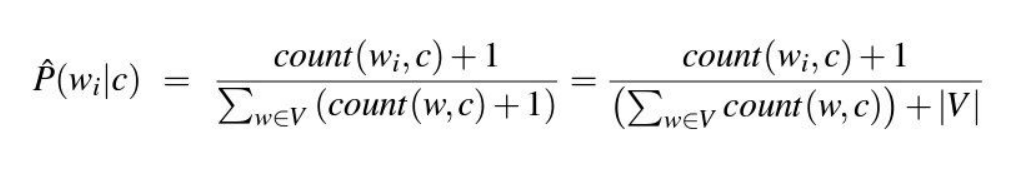

In [7]:
class Classifier:
    def __init__(self, df, pre_process: bool, additive_smoothing: bool):
        self.df = df
        self.pre_processor = PreProcessor(df)
        self.pre_process = pre_process
        self.additive_smoothing = additive_smoothing
        self.recommended_words_frequencies = dict()
        self.not_recommended_words_frequencies = dict()
        self.recommended_likelihood_probabilities = dict()
        self.not_recommended_likelihood_probabilities = dict()
        self.recommended_prior_probability = None
        self.not_recommended_prior_probability = None
        self.recommended_words_count = None
        self.not_recommended_words_count = None
        self.recommended_zero_count = 0
        self.not_recommended_zero_count = 0

    def calculate_words_frequency(self, words: List[str], recommended: bool):
        for word in words:
            if (
                word not in self.recommended_words_frequencies
                or word not in self.not_recommended_words_frequencies
            ):
                self.recommended_words_frequencies[word] = 0
                self.not_recommended_words_frequencies[word] = 0
            else:
                if recommended:
                    self.recommended_words_frequencies[word] += 1
                else:
                    self.not_recommended_words_frequencies[word] += 1

    def calculate_prior_probabilities(self):
        value_counts = train_data["recommend"].value_counts()
        self.recommended_prior_probability = value_counts.recommended / (
            value_counts.recommended + value_counts.not_recommended
        )
        self.not_recommended_prior_probability = value_counts.not_recommended / (
            value_counts.recommended + value_counts.not_recommended
        )

    def calculate_likelihood_probabilities(self):
        alpha = 0
        if self.additive_smoothing:
            alpha = 1
        self.recommended_words_count = sum(self.recommended_words_frequencies.values())
        for word, freq in self.recommended_words_frequencies.items():
            self.recommended_likelihood_probabilities[word] = (freq + alpha) / (
                self.recommended_words_count + self.recommended_words_count * alpha
            )
        self.not_recommended_words_count = sum(
            self.not_recommended_words_frequencies.values()
        )
        for word, freq in self.not_recommended_words_frequencies.items():
            self.not_recommended_likelihood_probabilities[word] = (freq + alpha) / (
                self.not_recommended_words_count
                + self.not_recommended_words_count * alpha
            )

    def train(self):
        if self.pre_process:
            self.pre_processor.pre_process()
        else:
            self.pre_processor.simple_pre_process()
        self.df.apply(
            lambda row: self.calculate_words_frequency(
                row["tokenized"], row["recommend"] == "recommended"
            ),
            axis=1,
        )
        self.calculate_prior_probabilities()
        self.calculate_likelihood_probabilities()

    def predict(self, words: List[str]):
        sum_recommended = math.log(self.recommended_prior_probability)
        sum_not_recommended = math.log(self.not_recommended_prior_probability)
        for word in words:
            if word in self.recommended_likelihood_probabilities:
                if self.recommended_likelihood_probabilities[word] == 0:
                    sum_recommended = 0
                    break
                if self.not_recommended_likelihood_probabilities[word] == 0:
                    sum_not_recommended = 0
                    break
                sum_recommended += math.log(
                    self.recommended_likelihood_probabilities[word]
                )
                sum_not_recommended += math.log(
                    self.not_recommended_likelihood_probabilities[word]
                )
            else:
                sum_recommended += math.log(1 / self.recommended_words_count)
                sum_not_recommended += math.log(1 / self.not_recommended_words_count)
        if sum_not_recommended == 0:
            self.not_recommended_zero_count += 1
            return "recommended"
        if sum_recommended == 0:
            self.recommended_zero_count += 1
            return "not_recommended"
        if sum_recommended > sum_not_recommended:
            return "recommended"
        else:
            return "not_recommended"

    def run(self, test_df):
        test_pre_processor = PreProcessor(test_df)
        if self.pre_process:
            test_pre_processor.pre_process()
        else:
            test_pre_processor.simple_pre_process()
        test_df["prediction"] = test_df.apply(
            lambda row: self.predict(row["tokenized"]), axis=1
        )

## Evaluation
We use Accuracy, Precision, Recall and F1 score to evaluate our model.

### The problem with just using precision or recall
for example lets assume that we are creating a model to classify banking transactions into Fraud and Not Fraud classes.  
ussually there is a little percent of fraud transactions in the whole transactions data.  

Recall = frauds correctly identified / (frauds correctly identified + frauds incorrectly labeled as not frauds)  

Lets assume that our model lablels every transaction as fraud so according to the earlier equation we have a recall of 100%  
But obiously this is not a good model because we are false labeling lots of none fraud transactions and interrupt them.
And according to the Precision formula:

Precision = frauds correctly identified / (frauds correctly identified + transactions incorrectly labeled as fraud)  

We see that we are getting a really low precision but a high recall and its not a good model.

### F1 Score
this score uses Harmonic Mean and uses both precision and recall to show how good our models is working.  
We use this mean method so a model with recall 100% and precision 0% gets a low score.  And punishes the extreme value that was high at the cost of the other value.  
If we used the normal mean equation we will end up on a value that is higher and its not a good metric because we don't want both of precision and recall to be more than a certain threshold.

In [8]:
def evaluate_predictions(df):
    similarity = df["recommend"] == df["prediction"]
    row_occurrences = np.count_nonzero(similarity == True, axis=0)
    accuracy = row_occurrences / df.shape[0]
    correct_recommended_count = len(
        df[(df["recommend"] == df["prediction"]) & (df["prediction"] == "recommended")]
    )
    all_detected_recommended_count = len(df[df["prediction"] == "recommended"])
    total_recommended_count = len(df[df["recommend"] == "recommended"])
    precision = correct_recommended_count / all_detected_recommended_count
    recall = correct_recommended_count / total_recommended_count
    f1 = 2 * (precision * recall) / (precision + recall)
    print("**************************************")
    print("ACCURACY: " + "{:.2f}".format(accuracy * 100))
    print("PRECISION: " + "{:.2f}".format(precision * 100))
    print("RECALL: " + "{:.2f}".format(recall * 100))
    print("F1: " + "{:.2f}".format(f1 * 100))
    print("**************************************")
    return accuracy, precision, recall, f1

#### A. Using preprocessing and additive smoothing

In [9]:
classifier_a = Classifier(train_data.copy(), pre_process=True, additive_smoothing=True)
classifier_a.train()
test_data_copy_a = test_data.copy()
classifier_a.run(test_data_copy_a)
accuracy, precision, recall, f1 = evaluate_predictions(test_data_copy_a)
accs = []
precisions = []
recalls = []
f1s = []
accs.append(accuracy)
precisions.append(precision)
recalls.append(recall)
f1s.append(f1)

**************************************
ACCURACY: 92.12
PRECISION: 93.09
RECALL: 91.00
F1: 92.04
**************************************


#### B. Just using additive smoothing

In [10]:
classifier_b = Classifier(train_data.copy(), pre_process=False, additive_smoothing=True)
classifier_b.train()
test_data_copy_b = test_data.copy()
classifier_b.run(test_data_copy_b)
accuracy, precision, recall, f1 = evaluate_predictions(test_data_copy_b)
accs.append(accuracy)
precisions.append(precision)
recalls.append(recall)
f1s.append(f1)

**************************************
ACCURACY: 92.00
PRECISION: 91.18
RECALL: 93.00
F1: 92.08
**************************************


#### C. Just using preprocessing

In [11]:
classifier_c = Classifier(train_data.copy(), pre_process=True, additive_smoothing=False)
classifier_c.train()
test_data_copy_c = test_data.copy()
classifier_c.run(test_data_copy_c)
accuracy, precision, recall, f1 = evaluate_predictions(test_data_copy_c)
accs.append(accuracy)
precisions.append(precision)
recalls.append(recall)
f1s.append(f1)

**************************************
ACCURACY: 73.50
PRECISION: 84.81
RECALL: 57.25
F1: 68.36
**************************************


#### D. Using nothing

In [12]:
classifier_d = Classifier(
    train_data.copy(), pre_process=False, additive_smoothing=False
)
classifier_d.train()
test_data_copy_d = test_data.copy()
classifier_d.run(test_data_copy_d)
accuracy, precision, recall, f1 = evaluate_predictions(test_data_copy_d)
accs.append(accuracy)
precisions.append(precision)
recalls.append(recall)
f1s.append(f1)

**************************************
ACCURACY: 72.62
PRECISION: 82.44
RECALL: 57.50
F1: 67.75
**************************************


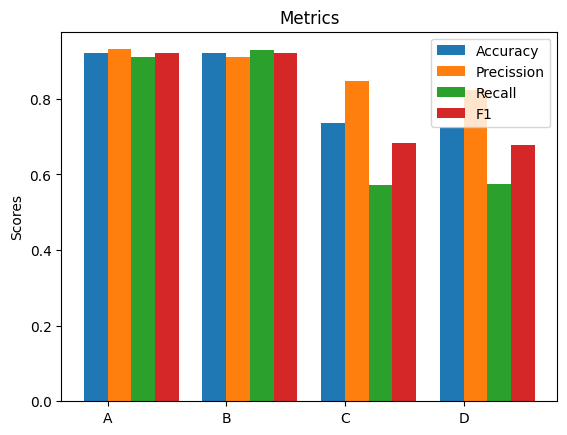

In [13]:
N = 4

ind = np.arange(N)
width = 0.2
plt.bar(ind, accs, width, label="Accuracy")
plt.bar(ind + width, precisions, width, label="Precission")
plt.bar(ind + 2 * width, recalls, width, label="Recall")
plt.bar(ind + 3 * width, f1s, width, label="F1")

plt.ylabel("Scores")
plt.title("Metrics")

plt.xticks(ind + width / 2, ("A", "B", "C", "D"))
plt.legend(loc="best")
plt.show()

### Evaluation results
As we see we get the highest value for our metrics using both preprocessing of data and additive smoothing.  
It's because of that in preprocessing we made our data more usable for the training phase and additive smoothing to remove the zero effect.  
And Obviously we have a little decrease in our values not using preprocessing. Not using preprocessing makes our initial data a little less usable for our model.  
But the highest decline in our metrics is when we turn off the additive smoothing flag.  
It causes most of our data to become zero and false labeling some of them.

You can observe the count of zero values compared between using additive smoothing and not using it below:

In [14]:
print("Zero count using additive smoothing:")
print(classifier_a.recommended_zero_count)
print("Zero count without using additive smoothing: ")
print(classifier_d.recommended_zero_count)

Zero count using additive smoothing:
0
Zero count without using additive smoothing: 
415


In [15]:
test_data_copy_a[test_data_copy_a["recommend"] != test_data_copy_a["prediction"]].iloc[
    0:5, :
]

,title,comment,recommend,title_comment,tokenized,prediction
0,وری گود,تازه خریدم یه مدت کار بکنه مشخص میشه کیفیت قطعاتش,recommended,وری گود تازه خریدم یه مدت کار بکنه مشخص میشه ک...,"[وری, گود, تازه, خریدم, یه, کار, بکنه, میشه, ک...",not_recommended
8,نقد پس از خرید,سلام ، راحت شدم از کابل شارژ ، توصیه میشود به ...,recommended,نقد پس از خرید سلام راحت شدم از کابل شارژ توصی...,"[نقد, خرید, سلام, راحت, شدم, کابل, شارژ, توصیه...",not_recommended
17,تستر پرادا کندی فلورال,من این ادو تویلتو خریدم \r\nبر خلاف اینکه نوشت...,recommended,تستر پرادا کندی فلورال من این ادو تویلتو خریدم...,"[تستر, پرادا, کندی, فلورال, ادو, تویلتو, خریدم...",not_recommended
27,کت مناسب,برای پسرم تهیه کردم خیلی قشنگه دوخت عالی داره ...,recommended,کت مناسب برای پسرم تهیه کردم خیلی قشنگه دوخت ع...,"[کت, پسرم, قشنگه, دوخت, داره, بعده, شستشو, نکر...",not_recommended
56,جنس و زیبایی,زیبا هستش از مدل های دیگه مثل پارس ... بنظرم ز...,recommended,جنس و زیبایی زیبا هستش از مدل‌های دیگه مثل پار...,"[جنس, زیبایی, زیبا, هستش, مدل‌های, دیگه, پارس,...",not_recommended


In [16]:
words = (
    test_data_copy_a[test_data_copy_a["recommend"] != test_data_copy_a["prediction"]]
    .iloc[0]
    .tokenized
)

In [17]:
for word in words:
    print("****************************************************")
    print("WORD: " + word)
    print(
        "RECOMMENDED LIKELIHOOD: "
        + str(classifier_a.recommended_likelihood_probabilities[word])
    )
    print(
        "NOT RECOMMENDED LIKELIHOOD: "
        + str(classifier_a.not_recommended_likelihood_probabilities[word])
    )

****************************************************
WORD: وری
RECOMMENDED LIKELIHOOD: 1.5841333206602666e-05
NOT RECOMMENDED LIKELIHOOD: 8.579272477693891e-06
****************************************************
WORD: گود
RECOMMENDED LIKELIHOOD: 1.5841333206602666e-05
NOT RECOMMENDED LIKELIHOOD: 8.579272477693891e-06
****************************************************
WORD: تازه
RECOMMENDED LIKELIHOOD: 0.00041187466337166934
NOT RECOMMENDED LIKELIHOOD: 0.0003774879890185312
****************************************************
WORD: خریدم
RECOMMENDED LIKELIHOOD: 0.004681113962551088
NOT RECOMMENDED LIKELIHOOD: 0.00440974605353466
****************************************************
WORD: یه
RECOMMENDED LIKELIHOOD: 0.004182111966543104
NOT RECOMMENDED LIKELIHOOD: 0.0043668496911461905
****************************************************
WORD: کار
RECOMMENDED LIKELIHOOD: 0.002447485980420112
NOT RECOMMENDED LIKELIHOOD: 0.0032944406314344542
**********************************************

As we can see in this example the word گود has a lower likelihood in recommended dataset and this is causing the problem.  
some of the acts that may affected some of rows to be false labeled these may be the following:  
* just merging the title and comment and not giving weight to none of them  
* we could have used more high quality stemming and lemmatization but hazm has a restrection on this.  
* small dataset
